In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DataGenerator import ImbalanceGenerator
from sklearn.model_selection import train_test_split
from Hierarchy import EngineTaxonomy
from anytree import RenderTree
import numpy as np
import random
from pathlib import Path
import pandas as pd
import sklearn.metrics as skm
from fairlearn.metrics import MetricFrame
from pymfe.mfe import MFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from fairlearn.metrics import count
from functools import partial
from fairlearn.metrics import count
from dcm import dcm

In [32]:
metric_mapping = {'c1': "Class entropy", "c2": "Imbalance Degree", "f1v.mean": "Fishers DR","f1.mean": "Fishers DR", "f2.mean": "Class Overlap", "vdu": "Dunn Index",
                 "n1": "Border Points", "n2.mean": "Inter/Intra Class Dist", "sil": "SIL", "n3.mean": "NN Error", "ch": "CHI"}

acc_per_ci = {'cls_imbalance': [], 'accuracy': [], 'accuracy Type': []}
ci_mapping = {'very_balanaced': 'Very Balanced'}
c = 20
f = 50
gi = "imbalanced"
gs = 0.5
n = 1000

for ci in ["very_balanced","balanced", "medium", "imbalanced", "very_imbalanced"]:
    print("-----------------------")
    print(ci)
    generator = ImbalanceGenerator(n_features=f,
                               n=n,
                               c=c,
                               features_remove_percent=0,
                               hardcoded=False,
                               group_imbalance=gi,
                               cls_imbalance=ci,
                               class_overlap=1.5,
                               root=EngineTaxonomy().create_taxonomy(),
                               gs=gs,
                               n_group_features=10)
    df = generator.generate_data_with_product_hierarchy()
    X, y = df[[f"F{i}" for i in range(f)]].to_numpy(), df["target"].to_numpy()

    df["counter"] = df.groupby("target")["target"].transform('count')
    df_train, df_test = train_test_split(df, train_size=0.7, stratify=df["target"])

    X_train, y_train = df_train[[f"F{i}" for i in range(50)]], df_train["target"]
    X_test, y_test = df_test[[f"F{i}" for i in range(50)]], df_test["target"]
    model_X = RandomForestClassifier()
    model_X.fit(X_train, y_train)
    y_pred_X = model_X.predict(X_test)

    mf_X = MetricFrame({'accuracy': skm.accuracy_score, 
                        'F1': partial(skm.f1_score, average='weighted'), 
                        'prec': partial(skm.precision_score, average='weighted'), 
                        'recall': partial(skm.recall_score, average='weighted'),
                                'count': count},
                     y_true=y_test,
                     y_pred=y_pred_X,
                     sensitive_features=df_test['target'])
    print(mf_X.by_group)
    frame = mf_X.by_group
    frame["accuracy"] = frame["accuracy"] * frame["count"]
    acc_per_ci["cls_imbalance"].append(ci)
    acc_per_ci["accuracy"].append(frame["accuracy"].sum() / sum(frame["count"]))
    acc_per_ci["accuracy Type"].append("All")
    
    # Minority Classes
    acc_per_ci["cls_imbalance"].append(ci)
    min_acc_frame = frame[frame['count'] < frame['count'].median()]
    min_acc = min_acc_frame['accuracy'].sum() / sum(min_acc_frame["count"])
    acc_per_ci["accuracy"].append(min_acc)
    acc_per_ci["accuracy Type"].append("Minority")
    
    
    # Majority Classes
    maj_acc_frame = frame[frame['count'] >= frame['count'].median()]
    maj_acc = maj_acc_frame['accuracy'].sum() / sum(maj_acc_frame["count"])
    acc_per_ci["cls_imbalance"].append(ci)
    #min_acc = frame[frame['count'] < frame['count'].median()]['accuracy'].mean()
    acc_per_ci["accuracy"].append(maj_acc)
    acc_per_ci["accuracy Type"].append("Majority")
    
    print(f"minority: {frame[frame['count'] < frame['count'].median()]['accuracy'].sum()}")
    print(f"majority: {frame[frame['count'] >= frame['count'].median()]['accuracy'].sum()}")

-----------------------
very_balanced
features that are currently not used: []


 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use 

        accuracy        F1 prec    recall count
target                                         
0       0.166667  0.285714  1.0  0.166667     6
1       0.588235  0.740741  1.0  0.588235    34
2       0.578947  0.733333  1.0  0.578947    38
3       0.333333       0.5  1.0  0.333333    21
4       0.391304    0.5625  1.0  0.391304    23
5            0.4  0.571429  1.0       0.4    20
6       0.214286  0.352941  1.0  0.214286    14
7         0.1875  0.315789  1.0    0.1875    16
8            0.1  0.181818  1.0       0.1    10
9       0.545455  0.705882  1.0  0.545455    11
10           0.0       0.0  0.0       0.0     6
11           0.3  0.461538  1.0       0.3    10
12      0.416667  0.588235  1.0  0.416667    12
13           0.4  0.571429  1.0       0.4    10
14      0.533333  0.695652  1.0  0.533333    15
15      0.529412  0.692308  1.0  0.529412    17
16      0.272727  0.428571  1.0  0.272727    11
17           0.5  0.666667  1.0       0.5    10
18      0.111111       0.2  1.0  0.11111

 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 i

        accuracy        F1 prec    recall count
target                                         
0          0.375  0.545455  1.0     0.375     8
1       0.777778     0.875  1.0  0.777778    45
2       0.266667  0.421053  1.0  0.266667    30
3       0.785714      0.88  1.0  0.785714    28
4            0.5  0.666667  1.0       0.5    20
5       0.724138      0.84  1.0  0.724138    29
6            0.4  0.571429  1.0       0.4    15
7       0.222222  0.363636  1.0  0.222222    18
8            0.6      0.75  1.0       0.6    10
9       0.285714  0.444444  1.0  0.285714     7
10         0.625  0.769231  1.0     0.625     8
11         0.375  0.545455  1.0     0.375     8
12           0.0       0.0  0.0       0.0     8
13      0.538462       0.7  1.0  0.538462    13
14      0.666667       0.8  1.0  0.666667    21
15           0.2  0.333333  1.0       0.2    10
16           0.0       0.0  0.0       0.0     8
17           0.0       0.0  0.0       0.0     5
18           0.0       0.0  0.0       0.

 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 i

        accuracy        F1 prec    recall count
target                                         
0            0.4  0.571429  1.0       0.4    10
1            0.8  0.888889  1.0       0.8    55
2           0.36  0.529412  1.0      0.36    25
3       0.857143  0.923077  1.0  0.857143    35
4       0.117647  0.210526  1.0  0.117647    17
5       0.933333  0.965517  1.0  0.933333    45
6       0.333333       0.5  1.0  0.333333    21
7            0.0       0.0  0.0       0.0     7
8            0.8  0.888889  1.0       0.8    10
9            0.0       0.0  0.0       0.0     6
10      0.666667       0.8  1.0  0.666667     9
11           0.0       0.0  0.0       0.0     6
12           0.0       0.0  0.0       0.0     2
13      0.857143  0.923077  1.0  0.857143    14
14      0.666667       0.8  1.0  0.666667    21
15           0.0       0.0  0.0       0.0     7
16           0.0       0.0  0.0       0.0     3
17           0.0       0.0  0.0       0.0     3
18           0.0       0.0  0.0       0.

 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 i

        accuracy        F1 prec    recall count
target                                         
0       0.909091  0.952381  1.0  0.909091    11
1       0.885246   0.93913  1.0  0.885246    61
2           0.55  0.709677  1.0      0.55    20
3       0.883721  0.938272  1.0  0.883721    43
4            0.6      0.75  1.0       0.6    10
5       0.935484  0.966667  1.0  0.935484    62
6            0.5  0.666667  1.0       0.5     8
7       0.111111       0.2  1.0  0.111111     9
8            0.9  0.947368  1.0       0.9    10
9            0.0       0.0  0.0       0.0     2
10      0.909091  0.952381  1.0  0.909091    11
11           0.0       0.0  0.0       0.0     4
12           0.0       0.0  0.0       0.0     1
13      0.933333  0.965517  1.0  0.933333    15
14      0.826087  0.904762  1.0  0.826087    23
15           0.0       0.0  0.0       0.0     2
16           0.0       0.0  0.0       0.0     4
17           0.0       0.0  0.0       0.0     2
18           0.0       0.0  0.0       0.

 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 i

 * Warning: FixedFormatter should only be used together with FixedLocator
2022-04-21 10:11:03 INFO matplotlib.mathtext: Substituting symbol X from STIXNonUnicode
2022-04-21 10:11:04 INFO matplotlib.mathtext: Substituting symbol X from STIXNonUnicode
2022-04-21 10:11:04 INFO matplotlib.mathtext: Substituting symbol X from STIXNonUnicode
2022-04-21 10:11:04 INFO matplotlib.mathtext: Substituting symbol X from STIXNonUnicode
2022-04-21 10:11:04 INFO matplotlib.mathtext: Substituting symbol X from STIXNonUnicode
2022-04-21 10:11:04 INFO matplotlib.mathtext: Substituting symbol X from STIXNonUnicode
2022-04-21 10:11:04 INFO matplotlib.mathtext: Substituting symbol X from STIXNonUnicode
2022-04-21 10:11:04 INFO matplotlib.mathtext: Substituting symbol X from STIXNonUnicode
2022-04-21 10:11:04 INFO matplotlib.mathtext: Substituting symbol X from STIXNonUnicode
2022-04-21 10:11:04 INFO matplotlib.mathtext: Substituting symbol X from STIXNonUnicode
2022-04-21 10:11:04 INFO matplotlib.mathtext: 

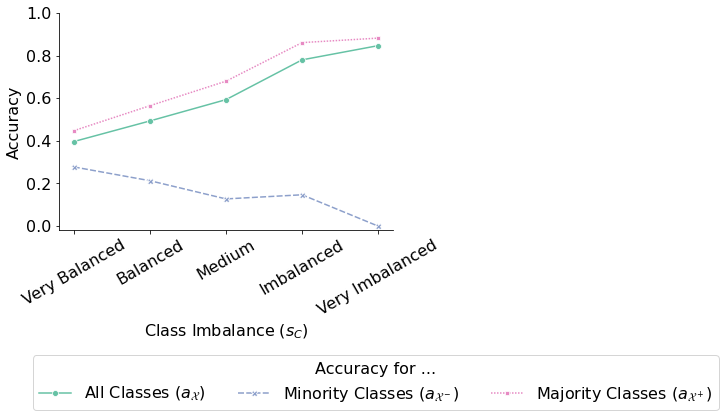

In [33]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
font = {#'family' : 'normal',
        #'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

palette = sns.color_palette("Set2")[0:1] + sns.color_palette("Set2")[2:4]
ax = sns.lineplot(data=pd.DataFrame(acc_per_ci), x="cls_imbalance", y="accuracy", hue="accuracy Type", style="accuracy Type", markers=True, palette=palette)
plt.legend(bbox_to_anchor=(-0.1, -0.7), ncol=3, loc="center left", title="Accuracy for ...", 
           labels=[r"All Classes ($a_{\mathcal{X}}$)",
                   r"Minority Classes ($a_{\mathcal{X}^-})$", r"Majority Classes ($a_{\mathcal{X}^+}$)", ]) 
ax.set_xticklabels(["Very Balanced","Balanced","Medium","Imbalanced", "Very Imbalanced"], rotation=30)
ax.set_xlabel(r"Class Imbalance ($s_C$)")
#ax.set_ylabel("Complexity Measure Value")
ax.set_ylim([-0.02,1.0])
#plt.legend(bbox_to_anchor=(-0.1, -0.3), ncol=7, loc="center left", title="Complexity Measures")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Accuracy")
plt.savefig(f"evaluation/Figures/C1_accuracy_min_maj.pdf", bbox_inches='tight')

In [4]:
c = 30
f = 50
gi = "medium"
gs = 0.5
n = 1000

for ci in ["very_balanced","balanced", "medium", "imbalanced", "very_imbalanced"]:
    print("-----------------------")
    print(ci)
    generator = ImbalanceGenerator(n_features=f,
                               n=n,
                               c=c,
                               features_remove_percent=0,
                               hardcoded=False,
                               group_imbalance=gi,
                               cls_imbalance=ci,
                               class_overlap=1.5,
                               root=EngineTaxonomy().create_taxonomy(),
                               gs=gs,
                               n_group_features=10)
    df = generator.generate_data_with_product_hierarchy()

    gini = generator.gini(df["target"].to_numpy())
    print(gini)

-----------------------
very_balanced
features that are currently not used: []
0.4299333333333334
-----------------------
balanced
features that are currently not used: []
0.47586666666666666
-----------------------
medium
features that are currently not used: []
0.5606666666666669
-----------------------
imbalanced
features that are currently not used: []
0.6215333333333335
-----------------------
very_imbalanced
features that are currently not used: []
0.6505333333333334


In [22]:
from sklearn.impute import KNNImputer
def extract_mfes(X, y, meta_feature_set, summary=["mean"], groups=["all"]):
    mfe = MFE(groups=groups, features=meta_feature_set,
              summary=summary)
    mfe.fit(X, y)
    ft = mfe.extract()
    return ft

metric_mapping = { "f1v.mean": "Fishers DRv", "f1.mean": "Fishers DR",
                 "n1": "Border Points",  "n3.mean": "NN Error"}

acc_per_ci = {'cls_imbalance': [], 'accuracy': [], 'accuracy Type': []}
ci_mapping = {'very_balanaced': 'Very Balanced'}
c = 20
f = 50
gi = "imbalanced"
gs = 0.5
n = 1000

complexity_metrics = ["f1v", "f1", "n1", "n3"]
stats = {"cls_imbalance": [], "Fishers DRv": [], "Fishers DR": [], "Border Points": [], "NN Error": []}
for ci in ["very_balanced","balanced", "medium", "imbalanced", "very_imbalanced"]:
    print("-----------------------")
    print(ci)
    generator = ImbalanceGenerator(n_features=f,
                               n=n,
                               c=c,
                               features_remove_percent=0,
                               hardcoded=False,
                               group_imbalance=gi,
                               cls_imbalance=ci,
                               class_overlap=1.5,
                               root=EngineTaxonomy().create_taxonomy(),
                               gs=gs,
                               n_group_features=10)
    df = generator.generate_data_with_product_hierarchy()
    X, y = df[[f"F{i}" for i in range(f)]].to_numpy(), df["target"].to_numpy()
    X = KNNImputer().fit_transform(X)
    ft = extract_mfes(X, y, complexity_metrics)

    for metric, value in zip(ft[0], ft[1]):
        print(f"{metric_mapping[metric]}: {value}")
        stats[f"{metric_mapping[metric]}"].append(value)
    stats["cls_imbalance"].append(ci)


-----------------------
very_balanced
features that are currently not used: []
Fishers DR: 0.4521552378419101
Fishers DRv: 0.029810011354566606
Border Points: 0.66
NN Error: 0.493
-----------------------
balanced
features that are currently not used: []
Fishers DR: 0.4681509387787728
Fishers DRv: 0.02677547276619369
Border Points: 0.591
NN Error: 0.451
-----------------------
medium
features that are currently not used: []
Fishers DR: 0.4084657007634489
Fishers DRv: 0.03602381961653887
Border Points: 0.511
NN Error: 0.358
-----------------------
imbalanced
features that are currently not used: []
Fishers DR: 0.39125751159443084
Fishers DRv: 0.05530862245050983
Border Points: 0.388
NN Error: 0.258
-----------------------
very_imbalanced
features that are currently not used: []
Fishers DR: 0.33804862819067133
Fishers DRv: 0.08842929655508791
Border Points: 0.281
NN Error: 0.178


In [23]:
stats_df = pd.DataFrame(stats)
c1_parameters = ["cls_imbalance"]
c1_measures = ["Fishers DR","Fishers DRv","Border Points", "NN Error"]
complexity_measures_df = stats_df[c1_parameters + c1_measures]

In [24]:
c1_melt_df = complexity_measures_df.melt(c1_parameters, var_name="Complexity Measure", value_name="Value of Complexity Measure")
c1_melt_df["Value of Complexity Measure"] = c1_melt_df["Value of Complexity Measure"].astype(float)

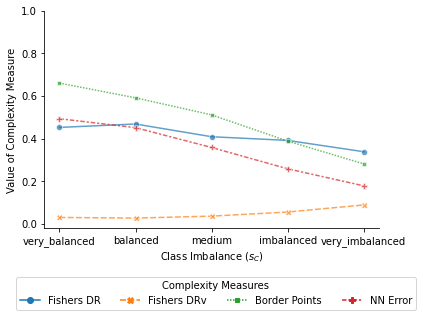

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
x_labels = {'cls_imbalance': r'Class Imbalance ($s_C$)'}
x_value = 'cls_imbalance'
plt.figure()
ax = sns.lineplot(data=c1_melt_df, x=x_value, y="Value of Complexity Measure", hue="Complexity Measure", style="Complexity Measure", ci=None, alpha=0.7, markers=True)
#ax.invert_yaxis()
plt.legend(bbox_to_anchor=(-0.1, -0.3), ncol=5, loc="center left", title="Complexity Measures") 
ax.set_xticks(c1_melt_df[x_value].unique())
ax.set_xlabel(x_labels[x_value])
#ax.set_ylabel("Complexity Measure Value")
ax.set_ylim([-0.02,1.0])
plt.legend(bbox_to_anchor=(-0.1, -0.3), ncol=7, loc="center left", title="Complexity Measures")
#plt.show()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(f"evaluation/Figures/C1_{x_value}_measures.pdf", bbox_inches='tight')